In [1]:
import pandas as pd
import os

In [2]:
os.chdir('C:/Users/POZOLE/Documents/pp/nohtyp/practice_algo_trading/modelos_dummys_ver2.0/data_modelos_dummys2.0')
data = pd.read_csv('modelo_supervisado_2.0.csv')

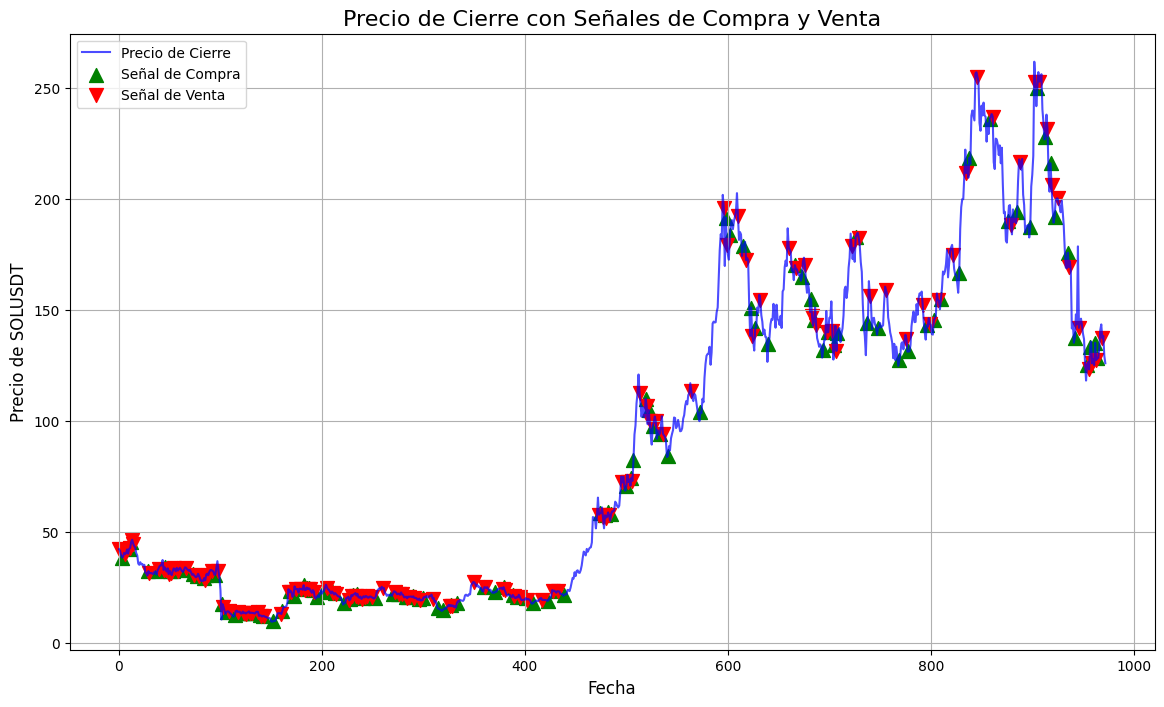

In [4]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(data['close'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(data.index[data['buy_signal'] == 1], data['close'][data['buy_signal'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(data.index[data['sell_signal'] == 1], data['close'][data['sell_signal'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)

# Personalización del gráfico
plt.title('Precio de Cierre con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {'SOLUSDT'}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Cargar los datos
df = data.copy()

# Definir las columnas predictoras y la variable objetivo
features = ['open', 'value', 'rsi', 'macd', 'adx', 'adp', 'adm', 'dri',
            'dlogri', 'avgtr', 'donch_hband', 'donch_lband', 'vwap']
target = 'signals'

# Mapear etiquetas de texto a numéricas (si es necesario)
mapping = {'buy': 0, 'sell': 1, 'hold': 2}
df[target] = df[target].map(mapping)

# Separar variables predictoras y objetivo
X = df[features]
y = df[target]

# Dividir en conjunto de entrenamiento y prueba (estratificado)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Crear DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definir un modelo FT-Transformer simple para datos tabulares
class FTTransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, d_token=32, n_heads=4, depth=3, mlp_ratio=4):
        super(FTTransformerClassifier, self).__init__()
        self.input_layer = nn.Linear(input_dim, d_token)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_token, nhead=n_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.classifier = nn.Sequential(
            nn.Linear(d_token, d_token * mlp_ratio),
            nn.ReLU(),
            nn.Linear(d_token * mlp_ratio, num_classes)
        )
        
    def forward(self, x):
        # x: (batch_size, input_dim)
        x = self.input_layer(x)  # (batch_size, d_token)
        # Los módulos Transformer esperan entrada de forma (seq_len, batch_size, d_model)
        # En datos tabulares, podemos tratar cada muestra como una secuencia de longitud 1.
        x = x.unsqueeze(0)  # (1, batch_size, d_token)
        x = self.transformer_encoder(x)  # (1, batch_size, d_token)
        x = x.squeeze(0)  # (batch_size, d_token)
        logits = self.classifier(x)  # (batch_size, num_classes)
        return logits

# Instanciar el modelo
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))
model = FTTransformerClassifier(input_dim=input_dim, num_classes=num_classes)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Entrenar el modelo FT-Transformer
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluar el modelo en el conjunto de prueba
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.numpy())
        all_targets.append(batch_y.numpy())

y_pred_ft = np.concatenate(all_preds)
y_test_ft = np.concatenate(all_targets)

accuracy = accuracy_score(y_test_ft, y_pred_ft)
print(f"\nAccuracy: {accuracy:.4f}")
print(classification_report(y_test_ft, y_pred_ft))

# Realizar predicciones para todo el conjunto de datos y asignarlas al DataFrame
# Normalizar todo el conjunto de datos (ya realizado en X_train y X_test)
X_all = scaler.transform(X)
X_all_tensor = torch.tensor(X_all, dtype=torch.float32)

model.eval()
with torch.no_grad():
    logits_all = model(X_all_tensor)
    preds_all = torch.argmax(logits_all, dim=1).numpy()



c:\Users\POZOLE\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/50, Loss: 0.7965
Epoch 2/50, Loss: 0.6889
Epoch 3/50, Loss: 0.6183
Epoch 4/50, Loss: 0.6047
Epoch 5/50, Loss: 0.5720
Epoch 6/50, Loss: 0.5719
Epoch 7/50, Loss: 0.5972
Epoch 8/50, Loss: 0.5778
Epoch 9/50, Loss: 0.5315
Epoch 10/50, Loss: 0.5392
Epoch 11/50, Loss: 0.5069
Epoch 12/50, Loss: 0.5218
Epoch 13/50, Loss: 0.5078
Epoch 14/50, Loss: 0.4972
Epoch 15/50, Loss: 0.4821
Epoch 16/50, Loss: 0.4685
Epoch 17/50, Loss: 0.4836
Epoch 18/50, Loss: 0.4895
Epoch 19/50, Loss: 0.4687
Epoch 20/50, Loss: 0.4814
Epoch 21/50, Loss: 0.4818
Epoch 22/50, Loss: 0.4678
Epoch 23/50, Loss: 0.4585
Epoch 24/50, Loss: 0.4707
Epoch 25/50, Loss: 0.4697
Epoch 26/50, Loss: 0.4764
Epoch 27/50, Loss: 0.4992
Epoch 28/50, Loss: 0.4649
Epoch 29/50, Loss: 0.4550
Epoch 30/50, Loss: 0.4344
Epoch 31/50, Loss: 0.4507
Epoch 32/50, Loss: 0.4592
Epoch 33/50, Loss: 0.4343
Epoch 34/50, Loss: 0.4600
Epoch 35/50, Loss: 0.4589
Epoch 36/50, Loss: 0.4648
Epoch 37/50, Loss: 0.4376
Epoch 38/50, Loss: 0.4311
Epoch 39/50, Loss: 0.

In [7]:
df['predictions'] = preds_all

# Opcional: convertir las predicciones numéricas de vuelta a texto
inverse_mapping = {0: 'buy', 1: 'sell', 2: 'hold'}
df['predictions_text'] = df['predictions'].map(inverse_mapping)

# Mostrar las primeras 20 filas comparando las etiquetas reales y las predicciones (en texto)
df['signals_text'] = df['signals'].map(inverse_mapping)
df[['signals_text', 'predictions_text']].head(20)


,signals_text,predictions_text
0,sell,sell
1,hold,hold
2,hold,sell
3,buy,sell
4,hold,hold
5,hold,hold
6,sell,sell
7,hold,hold
8,hold,hold
9,hold,sell


In [10]:
from sklearn.metrics import confusion_matrix

# Matriz de confusión
cm = confusion_matrix(df['signals'], df['predictions'])
print(cm)


[[ 58   1  63]
 [  2  99  22]
 [ 32 130 566]]


In [11]:
df['correcto'] = df['signals'] == df['predictions']
df[['signals', 'predictions', 'correcto']].head(20)


,signals,predictions,correcto
0,1,1,True
1,2,2,True
2,2,1,False
3,0,1,False
4,2,2,True
5,2,2,True
6,1,1,True
7,2,2,True
8,2,2,True
9,2,1,False


In [17]:
import numpy as np

# Si 'predicted_signals' está en df, haz lo siguiente:
df['buy_signal_pred'] = np.where(df['predictions_text'] == 'buy', 1, 0)
df['sell_signal_pred'] = np.where(df['predictions_text'] == 'sell', 1, 0)

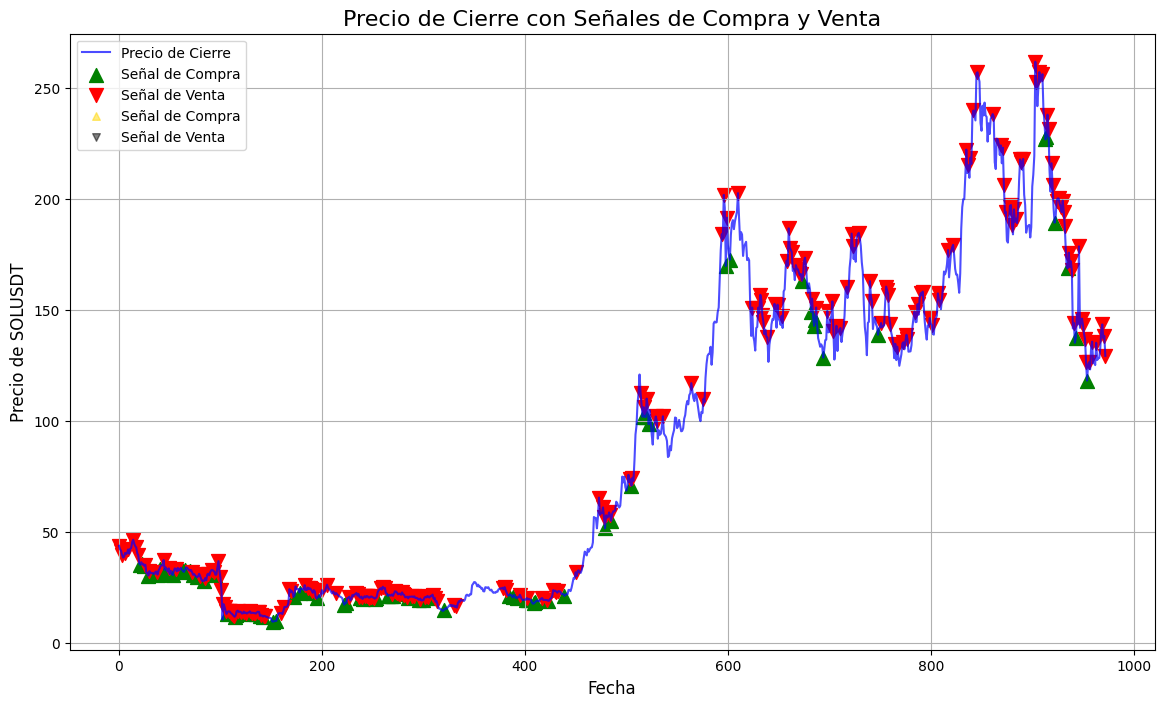

In [18]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(df['open'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(df.index[df['buy_signal_pred'] == 1], df['open'][df['buy_signal_pred'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(df.index[df['sell_signal_pred'] == 1], df['open'][df['sell_signal_pred'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)
plt.scatter(df.index[df['buy_signal'] == 1], df['open'][df['buy_signal'] == 1], 
            marker='^', color='gold', label='Señal de Compra', alpha=0.5, s=30)
plt.scatter(df.index[df['sell_signal'] == 1], df['open'][df['sell_signal'] == 1], 
            marker='v', color='black', label='Señal de Venta', alpha=0.5, s=30)

# Personalización del gráfico
plt.title('Precio de Cierre con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {'SOLUSDT'}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()

Compra a 35.265 en 2022-08-21 00:00:00
Venta a 35.25 en 2022-08-26 00:00:00 | ROI: -0.04%
Compra a 30.4 en 2022-08-29 00:00:00
Venta a 32.405 en 2022-08-30 00:00:00 | ROI: 6.60%
Compra a 31.095 en 2022-09-04 00:00:00
Venta a 32.145 en 2022-09-06 00:00:00 | ROI: 3.38%
Compra a 30.865 en 2022-09-07 00:00:00
Venta a 37.415 en 2022-09-13 00:00:00 | ROI: 21.22%
Compra a 32.96 en 2022-09-14 00:00:00
Venta a 33.67 en 2022-09-18 00:00:00 | ROI: 2.15%
Compra a 31.07 en 2022-09-19 00:00:00
Venta a 33.375 en 2022-09-25 00:00:00 | ROI: 7.42%
Compra a 32.32 en 2022-09-26 00:00:00
Venta a 31.94 en 2022-10-11 00:00:00 | ROI: -1.18%
Compra a 30.78 en 2022-10-12 00:00:00
Venta a 31.185 en 2022-10-18 00:00:00 | ROI: 1.32%
Compra a 27.995 en 2022-10-23 00:00:00
Venta a 29.26 en 2022-10-24 00:00:00 | ROI: 4.52%
Compra a 30.79 en 2022-11-03 00:00:00
Venta a 36.895 en 2022-11-06 00:00:00 | ROI: 19.83%
Compra a 13.135 en 2022-11-14 00:00:00
Venta a 14.31 en 2022-11-16 00:00:00 | ROI: 8.95%
Compra a 11.825 en

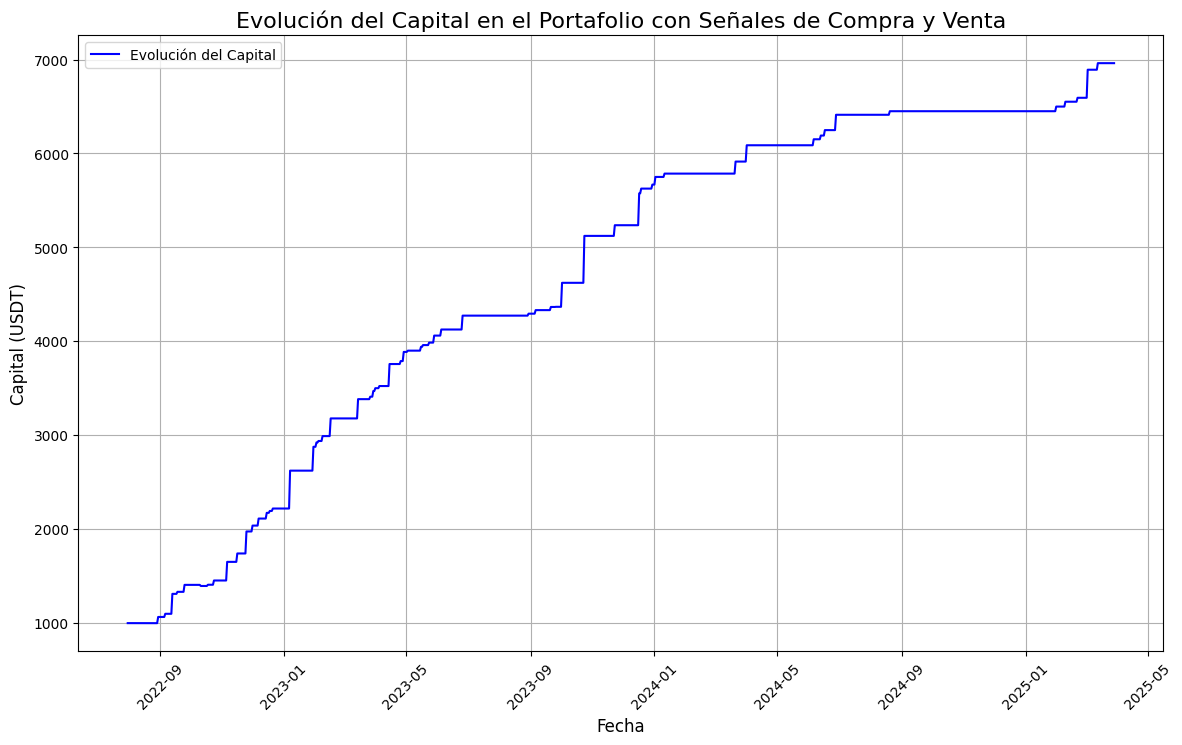

In [19]:
import pandas as pd

# Crear una copia del DataFrame
df_validation = df.copy()

# Inicializar las variables
capital_inicial = 1000  # Ejemplo de inversión inicial en USDT
capital = capital_inicial  # Capital actualizado durante las operaciones
buy_price = 0  # Precio al que se compró el activo
holding = False  # Estado de si se tiene una posición abierta

# Listas para almacenar resultados
capital_history = []  # Historial del capital a lo largo del tiempo
buy_prices = []  # Historial de precios de compra
sell_prices = []  # Historial de precios de venta

# Iterar a través de las filas del DataFrame
for index, row in df_validation.iterrows():
    # Señal de compra
    if row['buy_signal_pred'] == 1 and not holding:
        buy_price = row['open']
        holding = True  # Se abre la posición
        buy_prices.append(buy_price)
        print(f"Compra a {buy_price} en {df_validation['date'][index]}")
    
    # Señal de venta
    elif row['sell_signal_pred'] == 1 and holding:
        sell_price = row['open']
        roi = (sell_price - buy_price) / buy_price  # Cálculo del ROI
        capital += capital_inicial * roi  # Actualización del capital
        sell_prices.append(sell_price)
        holding = False  # Se cierra la posición
        print(f"Venta a {sell_price} en {df_validation['date'][index]} | ROI: {roi*100:.2f}%")
    
    capital_history.append(capital)  # Guardar capital actual

# Imprimir el capital final
print(f"Capital final: {capital:.2f} USDT")

# Opcional: Crear un DataFrame para visualizar el historial de capital
df_validation_capital = pd.DataFrame({
    'Date': df_validation['date'],
    'Capital': capital_history
})

# Graficar la evolución del capital a lo largo del tiempo
plt.figure(figsize=(14, 8))
plt.plot(df_validation_capital['Date'], df_validation_capital['Capital'], label='Evolución del Capital', color='blue')
plt.title('Evolución del Capital en el Portafolio con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Capital (USDT)', fontsize=12)
plt.grid(True)
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.show()


Capital Final: 3417.90 USDT
Tasa de Retorno Acumulado: 241.79%
Volatilidad Anualizada: 0.8915
Relación de Sharpe: -0.0082
Drawdown Máximo: -60.14%


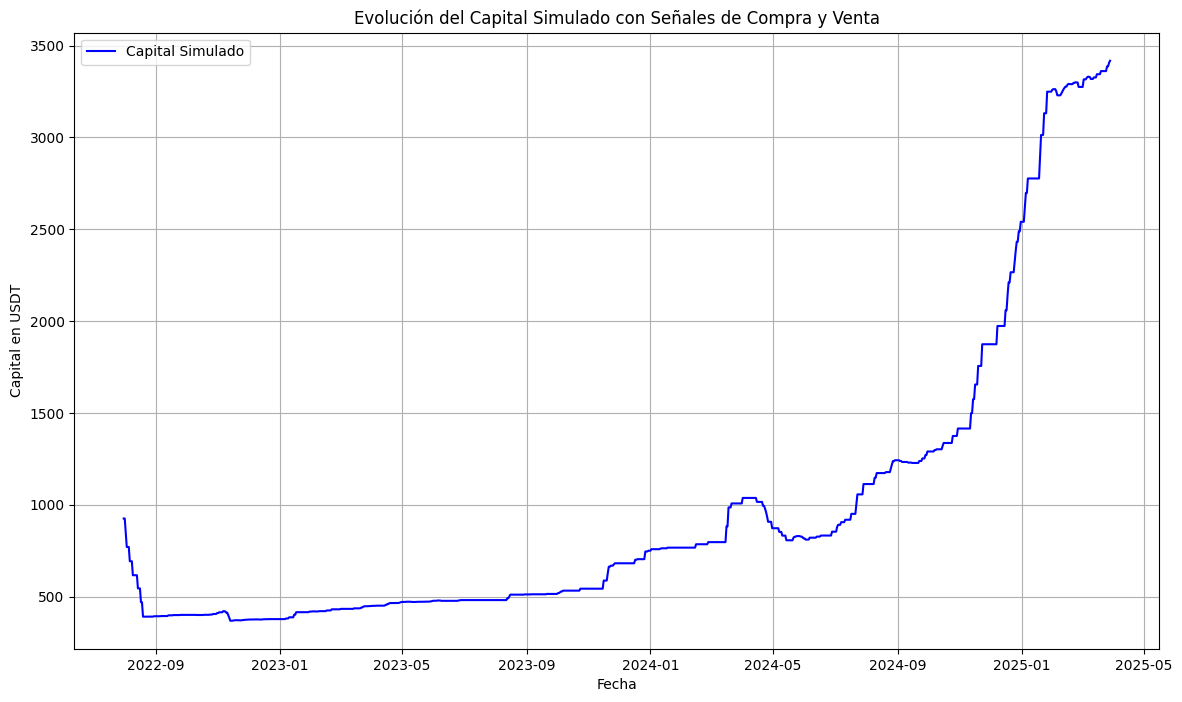

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Supongamos que tienes los datos necesarios con las señales predichas
# Aquí se toma el dataframe 'df' con las señales de compra y venta predichas

# Asegúrate de que las fechas estén en el formato correcto
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Calcula el retorno diario en base al precio 'open'
df['daily_return'] = df['open'].pct_change()

# Calcula el retorno acumulado de la inversión
initial_capital = 1000  # Capital inicial
df['capital'] = initial_capital * (1 + df['daily_return']).cumprod()

# Añadir señales de compra y venta al DataFrame
df['buy_signal'] = df['buy_signal_pred'] == 1
df['sell_signal'] = df['sell_signal_pred'] == 1

# Simular las compras y ventas
capital = initial_capital
capital_series = []

for i in range(len(df)):
    if df['buy_signal'].iloc[i]:
        buy_price = df['open'].iloc[i]
    if df['sell_signal'].iloc[i]:
        sell_price = df['open'].iloc[i]
        capital += (sell_price - buy_price)  # Calcular el retorno de la venta
    capital_series.append(capital)

df['capital_simulado'] = capital_series

# 1. Calcular el Drawdown
df['capital_max'] = df['capital_simulado'].cummax()
df['drawdown'] = df['capital_simulado'] - df['capital_max']
df['drawdown_pct'] = df['drawdown'] / df['capital_max'] * 100

# 2. Calcular la volatilidad (desviación estándar de los retornos diarios)
volatilidad = df['daily_return'].std() * np.sqrt(252)  # Volatilidad anualizada

# 3. Calcular la rentabilidad diaria promedio
rentabilidad_diaria = df['daily_return'].mean()

# 4. Calcular la relación de Sharpe
tasa_libre_riesgo = 0.01  # Asumimos una tasa libre de riesgo del 1%
sharpe_ratio = (rentabilidad_diaria - tasa_libre_riesgo) / volatilidad

# 5. Resultado Final
capital_final = df['capital_simulado'].iloc[-1]
tasa_retorno_acumulado = (capital_final - initial_capital) / initial_capital * 100

# Imprimir métricas de desempeño
print(f"Capital Final: {capital_final:.2f} USDT")
print(f"Tasa de Retorno Acumulado: {tasa_retorno_acumulado:.2f}%")
print(f"Volatilidad Anualizada: {volatilidad:.4f}")
print(f"Relación de Sharpe: {sharpe_ratio:.4f}")
print(f"Drawdown Máximo: {df['drawdown_pct'].min():.2f}%")

# Graficar la evolución del capital simulado
plt.figure(figsize=(14, 8))
plt.plot(df['date'], df['capital_simulado'], label='Capital Simulado', color='blue')
plt.title('Evolución del Capital Simulado con Señales de Compra y Venta')
plt.xlabel('Fecha')
plt.ylabel('Capital en USDT')
plt.grid(True)
plt.legend()
plt.show()


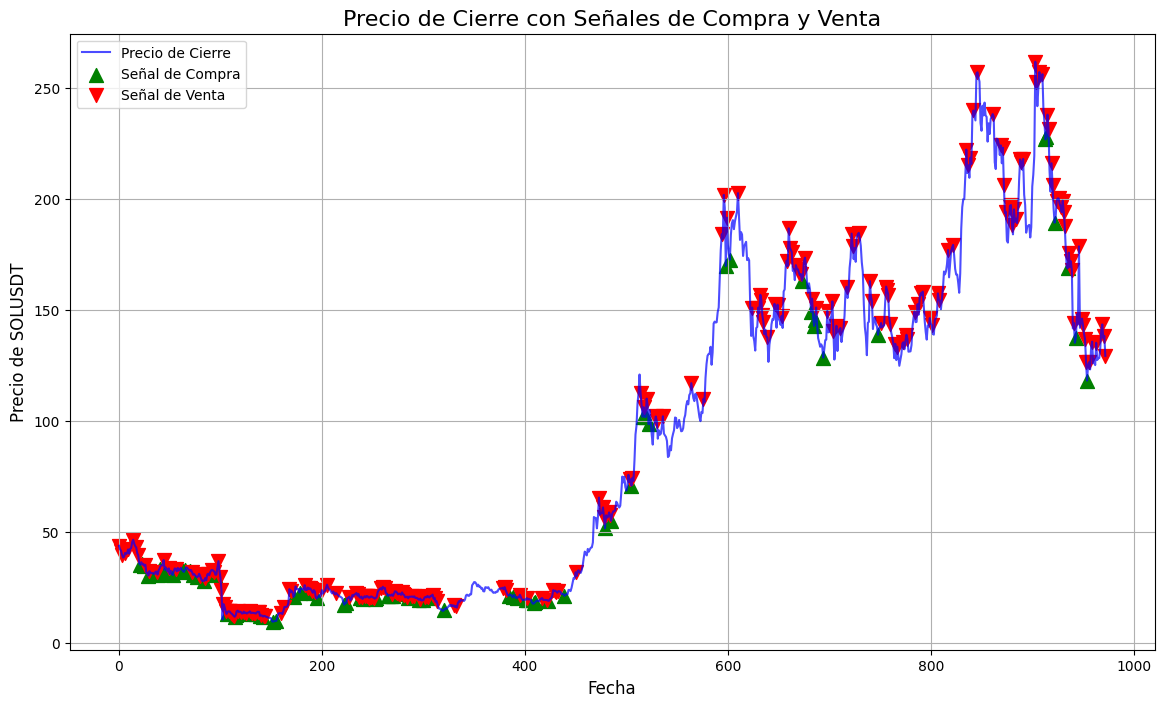

In [21]:
import matplotlib.pyplot as plt

# Crear gráfico de precios
plt.figure(figsize=(14, 8))
plt.plot(df['open'], label='Precio de Cierre', color='blue', alpha=0.7)

# Añadir señales de compra y venta
plt.scatter(df.index[df['buy_signal_pred'] == 1], df['open'][df['buy_signal_pred'] == 1], 
            marker='^', color='green', label='Señal de Compra', alpha=1, s=100)
plt.scatter(df.index[df['sell_signal_pred'] == 1], df['open'][df['sell_signal_pred'] == 1], 
            marker='v', color='red', label='Señal de Venta', alpha=1, s=100)


# Personalización del gráfico
plt.title('Precio de Cierre con Señales de Compra y Venta', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Precio de {'SOLUSDT'}', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Mostrar gráfico
plt.show()